In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Simulation_OpenSYK2/


/content/drive/MyDrive/Simulation_OpenSYK2


In [3]:
!pip install qutip


     |████████████████████████████████| 14.8 MB 22.2 MB/s 


In [4]:
#Import libraries 
import qutip as qt
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
from qutip.qip.operations import swap
import pickle
import json 
import os
from multiprocessing import Pool


In [5]:
#System variables

# w = 1e-1
# gamma = 1e-1

class OpenSYK():
  def __init__(self, w, gamma_w, w_g, N, gamma_beta, model):
    # Model
    self.Model= model
   
    # Central fermion strength 
    self.w= w
    self.w_g= w_g

    # Interaction strength
    self.g = (1/self.w_g)* self.w

    # Majorana fermions number
    self.N= N

    # Coupling function strength 
    self.gamma_w= gamma_w
    self.gamma= self.w*self.gamma_w
    self.gamma_beta = gamma_beta
    # Bath temperature
    self.beta = self.gamma*(1/self.gamma_beta)

    #number of fermions = [complex fermions + central fermion(model 1), complex fermions(model 2)]
    self.n1 = N//2+1
    self.n2 = N//2

    #model
   # self.model= model
  
  #Define fermion operators using the Jordan-Wigner transform (n or N//2)
  @property
  def fermion_operators(self):
    if self.Model==1:
      return [qt.tensor(*[qt.destroy(2) if i == j\
                  else (qt.sigmaz() if j < i\
                      else qt.identity(2))\
                          for j in range(self.n1)])\
                              for i in range(self.n1)]
    if self.Model==2:
      return [qt.tensor(*[qt.destroy(2) if i == j\
                  else (qt.sigmaz() if j < i\
                      else qt.identity(2))\
                          for j in range(self.n2)])\
                              for i in range(self.n2)]

  
  #Hamiltonian of the system SYK+central fermion
  @property
  def Hamiltonian1(self):
    N = self.N
    c_fermi = self.fermion_operators
    wg = np.zeros(self.n1)
    wg[0] = self.w/2 # isolated fermion energy
    wg[1:]= self.g   # interaction strength

    #random interaction matrix 
    K = np.random.randn(self.N,self.N) 
    K = 0.5*(K - K.T)

    # K_ab eigenenergies
    lbd= np.linalg.eigvals(K)
    lbd=[np.imag(lbd)[x] for x in range(0,len(lbd),2)]

    #define M
    M=np.zeros((self.n1)**2)
    M= M.reshape(self.n1,self.n1)
    M[0]= wg
    for x in range(self.n2): 
      M[x+1][x+1] =lbd[x]/2
    M = M + M.T
    epsilon = np.linalg.eigvals(M)

    #coupling constants and quasifermions normalizations constants
    norms= np.sqrt([1+self.g**2*sum(1/(lbd[i]-epsilon[j])**2 for i in range(len(lbd))) for j in range(len(epsilon))])
    random_c = np.array([1+self.g*sum(1/(lbd[i]-epsilon[j]) for i in range(len(lbd))) for j in range(len(epsilon))])
    random_c = (random_c/norms)**2
    random_cps = [N*self.gamma*(1+np.tanh(0.5*self.beta*epsilon[i]))*random_c[i] for i in range(len(random_c))]

    # diagonalized Hamiltonian
    H_d = sum([ epsilon[i]*(c_fermi[i].dag()*c_fermi[i]) for i in range(self.n2)]) 
    return  H_d, epsilon, lbd, random_cps, norms




In [6]:


def solve1(inputs):

  times, Model= inputs 
  N = Model.N
  c_fermi= Model.fermion_operators
  H, eps, lamb, coupl_c, quasi_norms = Model.Hamiltonian1
  
  #jump operators
  J_op = [np.sqrt(coupl_c[i])*c_fermi[i] for i in range(N//2+1)]
  
  #central fermion anihilation operator
  d = [c_fermi[i]/quasi_norms[i] for i in range(N//2+1)]
  D = sum(d)
  D_op= D.dag()*D

  #collapse operators
  C_op= [J_op[i].dag()*J_op[i] for i in  range(N//2+1)]

  #initial state
  psi_0 =qt.tensor(*[qt.basis(2,1) for j in range(N//2+1)])
  

  #Lindbladian eigenvalues 
  Lindbladian = qt.liouvillian(H, C_op)
  eps_L =Lindbladian.eigenenergies()
  #evolve and calculate expectation values for each quasi-fermion,d 
  out= qt.mesolve(H, psi_0, times, J_op, C_op)
  out_d = qt.mesolve(H, psi_0, times, J_op, D_op)
  rho= qt.mesolve(H, psi_0, times, J_op, [])
  return out, out_d, rho, eps, eps_L



In [7]:

P = {"w": [1e-1,1,1e1],"gamma/w":[100,10,1], "w/g": np.array([5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2, 5e2]),\
     "N":10, "gamma/beta" : np.array([1e-6, 1e-4, 1e-3,1e-2,1e-1, 1, 1e1,1e2,1e3]), "AverageNumber":50}

len_i= len(P["w"])
len_j= len(P["gamma/w"])
len_k= len(P["w/g"])
len_l= len(P["gamma/beta"])
times = np.arange(0,8,1e-2)

# Generate an especific model
def create_Model(i,j,k,l):
  return OpenSYK(P["w"][i], P["gamma/w"][j], P["w/g"][k], P["N"], P["gamma/beta"][l], 1 )





In [8]:
import sys 
# Multiprocessing function 
def solve_batch(args):
  i,j,k,l = args
  #number of iterations
  iterations = P["AverageNumber"]
  data= { "counts_d":[], "purity":[], "entropy":[], "eigenvalues":[], "eigenvalues_L":[]}
  try:
    end=8
    step= 1e-2
    times = np.arange(0,end,step)
    for m in range(iterations):
      
      if not(m%10):
        print(m)
      
      Model = create_Model(i,j,k,l)
      purity=[]
      entropy=[]
      eigenvalues=[]
      eigenvalues_L =[]
      N= P["N"]


      # Solve the master equation
      result_q, result_d, rho ,eig, eig_L = solve1((times, Model ))
      counts_d = result_d.expect
      rhot = rho.states
      eigenvalues.append(eig)
      eigenvalues_L.append(eig_L)

      for n in range(len(rhot)):
        # purity
        purity.append((rhot[n]**2).tr())
        #entropy
        entropy.append(qt.entropy_vn(rhot[n]))
      data["counts_d"].append(counts_d)
      data["eigenvalues"].append(eigenvalues)
      data["eigenvalues_L"].append(eigenvalues_L)
      data["purity"].append(purity)
      data["entropy"].append(entropy)

    print(i,j,k,l," process saved")
    with open('Data/w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)+'.pickle','wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 
  
  except:
    print(i,j,k,l," process failed")




In [ ]:


##################################################
#Calculate the time evolution of the system

#################################################


if __name__ == '__main__': 
  os.environ["QUTIP_IN_PARALLEL"]= "TRUE"
  process=[]
  with Pool(1) as p:
    i,j,k,l=0,0, 4,4
    # for k in [2,3]:
    #   for l in range(len_l):
    process.append(p.apply_async(solve_batch,(i,j,k,l)) )
    # process = np.array(process)
    # process= process.reshape(2 , len_l)
    # for n in range(2):
    #   for p in range(len_l):
      #   process[n][p].get()
    process[0].get()
    



0
10
20
30
40
0 0 4 4  process saved


In [9]:
x,y= np.meshgrid(np.arange(8),np.arange(8))
heble= np.array([y.reshape(-1),x.reshape(-1)])


In [ ]:
def test(arg,I,J):
  k,l = arg
  i,j= I,J
  args= i,j,k,l
  solve_batch(args)
  
qt.parallel_map(test,heble.T, task_args=(1,1,), num_cpus=8, progress_bar= True)




0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
1 1 0 0  process saved
0
1 1 0 4  process saved
0
1 1 0 2  process saved
0
1 1 0 7  process saved
0
1 1 0 6  process saved
0
1 1 0 5  process saved
0
1 1 0 1  process saved
10.9%. Run time: 1813.08s. Est. time left: 00:04:06:03
0
1 1 0 3  process saved
0
10
10
10
10
10
10
10


In [ ]:
data=[]
N=10
#for k in range(len_k):
k=4
for l in [4]:
  Model = create_Model(0,0,k,l)
  with open('Data/w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)+'.pickle','rb') as handle:
    data.append(pickle.load( handle))




In [ ]:
# import os

# files_to_rename = [ 'w_g'+'%.3f_'%(Models[i].w_g)+'N%.1f_'%(parameters["N"][1])+'gamma_beta%.2f'%(Models[i].gamma_beta)+'.pickle'for i in range(cases)]
# renamed_files = ['w_g'+'%.3f_'%(Models2[i].w_g)+'N%.1f_'%(parameters["N"][2])+'gamma_beta%.2f'%(Models[0].gamma_beta)+'.pickle'for i in range(cases)]
# folder=r"/content/drive/MyDrive/Simulation_OpenSYK2/"
# # Iterate through the folder
# for i in range(cases):
#    # construct current name using file name and path
#    old_name = files_to_rename[i]
#   # construct full file path
#    new_name = renamed_files[i]
#   # Renaming the file
#    os.rename(old_name, new_name)

# # verify the result
# res = os.listdir(folder)
# print(res)



['w_g20.000_N14.0_gamma_beta0.01.pickle', 'w_g17.889_N14.0_gamma_beta0.01.pickle', 'w_g9.444_N14.0_gamma_beta0.01.pickle', 'w_g11.556_N14.0_gamma_beta0.01.pickle', 'w_g13.667_N14.0_gamma_beta0.01.pickle', 'w_g15.778_N14.0_gamma_beta0.01.pickle', 'w_g7.333_N14.0_gamma_beta0.01.pickle', 'w_g5.222_N14.0_gamma_beta0.01.pickle', 'w_g3.111_N14.0_gamma_beta0.01.pickle', 'w_g1.000_N14.0_gamma_beta0.01.pickle']


Text(0.5, 1.0, 'ordered eigenenergies w_g11.56_N14_gamma_beta100.00')

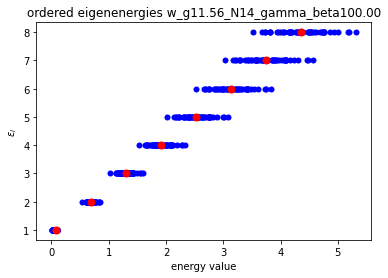

In [ ]:

i=5
count=[]
bin_edges=[]
bin_centers =[]
for d in data[i]["eigenvalues"]:
  c,b = np.histogram(d, bins=7) 
  count.append(c)
  bin_edges.append(b)
  
bin_edges = np.sort(bin_edges)
av_bin = bin_edges.sum(axis=0)
x = np.arange(1,9)

for bin in bin_edges:
  plt.scatter(bin,x,linewidth=0.01, c= "b")

plt.scatter(av_bin/50,x, linewidth =2, c ="r")
plt.xlabel("energy value")
plt.ylabel(r"$\epsilon_i$")
plt.title("eigenenergies "+'w_g'+'%.2f_'%(Models3[i].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f'%(Models3[0].gamma_beta))
#plt.savefig("eig"+'w_g'+'%.2f_'%(Models3[i].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f.jpg'%(Models3[0].gamma_beta))


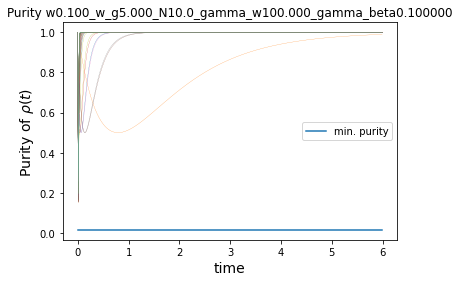

In [ ]:
k=4
l= 4
Model = create_Model(0,0,k,l)
end=6
step= 1e-2
times = np.arange(0,end,step)
#av_purity= [(np.array(data[l]["purity"]).sum(axis=0))/50 for l in range(cases)]
av_purity= (np.array(data[0]["purity"]).sum(axis=0))/50 
purity_min = [1/2**(P["N"]//2+1)]*len(times)
for i in range(P["AverageNumber"]):
  plt.plot(times,data[0]["purity"][i],linewidth=0.2)
#plt.plot(times, av_purity[l],label="average purity")
plt.plot(times,purity_min, label="min. purity")

plt.ylabel("Purity of $\\rho(t)$",fontsize=14)
plt.xlabel("time", fontsize=14)
plt.title("Purity "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta))
plt.legend()
#plt.savefig("purity"+'w_g'+'%.2f_'%(Models4[j].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f.jpg'%(Models4[0].gamma_beta))

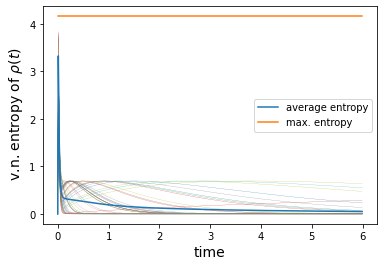

In [ ]:

j=8
end=6
step= 1e-2
times = np.arange(0,end,step)

av_entropy= [(np.array(data[j]["entropy"]).sum(axis=0))/50 for j in range(len_l)]
entropy_max= [np.log(2**(N//2+1))]*len(times)
for i in range(50):
   plt.plot(times,data[j]["entropy"][i],linewidth=0.2)
plt.plot(times, av_entropy[j],label="average entropy")
plt.plot(times,entropy_max, label="max. entropy")

plt.ylabel(" v.n. entropy of $\\rho(t)$",fontsize=14)
plt.xlabel("time", fontsize=14)
#plt.title("Entropy "+'w_g'+'%.2f_'%(Models6[j].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f'%(Models6[j].gamma_beta))
plt.legend()
#plt.savefig("Entropy"+'w_g'+'%.2f_'%(Models4[j].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f.jpg'%(Models4[0].gamma_beta))

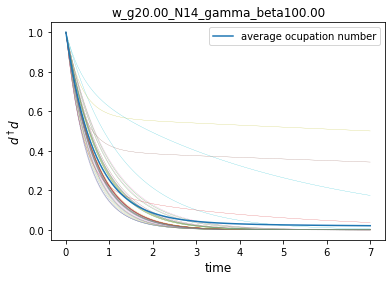

In [ ]:
j=-1
end=6
step= 1e-2
times = np.arange(0,end,step)
av_counts_d= [(np.array(data[j]["counts_d"]).sum(axis=0))/50 for j in range(cases)]
d_min = [min(av_counts_d[0])]*len(times)
for i in range(iterations):
  plt.plot(times,data[j]["counts_d"][i][0],linewidth=0.2)
plt.plot(times, av_counts_d[j][0],label="average ocupation number")
plt.ylabel("$d^\dagger d$",fontsize=12)
plt.xlabel("time", fontsize=12)
plt.title('w_g'+'%.2f_'%(Models6[j].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f'%(Models6[j].gamma_beta))
plt.legend()
#plt.savefig("OcupationNumber"+'w_g'+'%.2f_'%(Models4[j].w_g)+'N%.f_'%(parameters["N"][2])+'gamma_beta%.2f.jpg'%(Models4[0].gamma_beta))

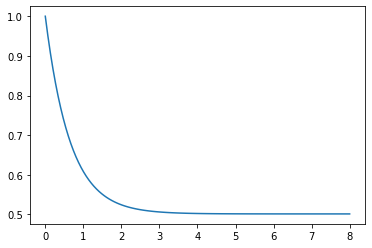

In [ ]:
from PIL import Image
DATA =[[]]*cases_an
for i in range(cases_an):
  for j in range(cases_an):
    with open('w_g'+'%.3f_'%(Model_animation[i][j].w_g)+'N%.1f_'%(Model_animation[i][j].N)+'gamma_beta%.2f'%(Model_animation[i][j].gamma_beta)+'.pickle','rb') as handle:
        DATA[i].append(pickle.load( handle))




Text(0.5, 0.98, 'w_g=0.010 N=10 gamma_beta=0.01')

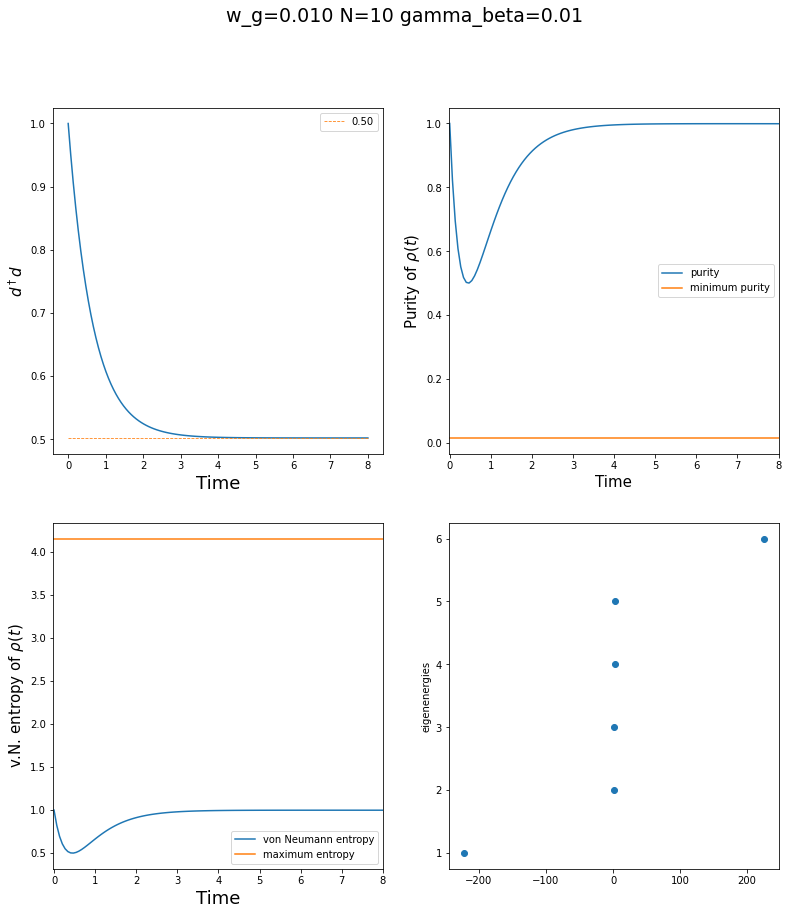

In [ ]:

#for j in range(iterations):
# for i in range(cases_an):
#   for j in range(cases_an):
i,j = 2,1

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(13,14))

purity_min = [1/2**(Model_animation[i][j].N//2+1)]*len(times)
entropy_max= [np.log(2**(Model_animation[i][j].N//2+1))]*len(times)
d_min = [min(DATA[i][j]["counts_d"][0][0])]*len(times)


# Central electron population
ax1.plot(times,np.real(DATA[i][j]["counts_d"][0][0]), '-')
ax1.plot(times,np.real(d_min), '--', label="%.2f"%(d_min[0]),linewidth=0.8)
ax1.set_xlabel('Time', fontsize=18)
ax1.set_ylabel(r'$d^\dagger d$', fontsize=15)
#ax2.set_xlim(0,10)
ax1.legend()

#Purity of the system
ax2.plot(times,DATA[i][j]["purity"][0],label="purity")
ax2.plot(times,purity_min,label="minimum purity")
ax2.set_xlim(-0.02,max(times))
ax2.set_xlabel('Time', fontsize=15)
ax2.set_ylabel("Purity of $\\rho(t)$", fontsize=15)
ax2.legend()

#Entropy of the system
ax3.plot(times,DATA[i][j]["purity"][0],label="von Neumann entropy")
ax3.set_xlim(-0.02,max(times))
ax3.plot(times,entropy_max,label="maximum entropy")
ax3.set_xlabel('Time', fontsize=18)
ax3.set_ylabel("v.N. entropy of $\\rho(t)$", fontsize=15)
ax3.legend()

#Eigenenergies of the system
x= len(DATA[i][j]["eigenvalues"][0][0])
ax4.scatter(np.sort(DATA[i][j]["eigenvalues"][0][0]),np.arange(1,x+1))
ax4.set_ylabel("eigenenergies")

fig.suptitle('w_g=%.3f '%(Model_animation[i][j].w_g)+'N=%.f '%(Model_animation[i][j].N)\
               +'gamma_beta=%.2f'%(Model_animation[i][j].gamma_beta), fontsize=19)
  #   plt.legend()
  # plt.savefig("AnimationOPSYK2/"+"Purity "+'w_g'+'%.2f_'%(Model_animation[j].w_g)+\
  #              'N%.f_'%(Model_animation[i][j].N)+'gamma_beta%.2f.jpg'%(Model_animation[i][j].gamma_beta))